In [ ]:
!pip install earthengine-api geemap tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00


In [1]:
import ee
import geemap
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Authenticate the Earth Engine API
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='ee-phiwokuhlemadulini747')


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [11]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Load ERA5-Land data for 2023
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
              .filterBounds(region_of_interest) \
              .filterDate('2023-01-01', '2023-12-31')

# Function to calculate wind speed from u10 and v10 components
def calc_wind_speed(image):
    u10 = image.select('u_component_of_wind_100m')
    v10 = image.select('v_component_of_wind_100m')
    wind_speed = u10.pow(2).add(v10.pow(2)).sqrt()  # Wind speed calculation
    return image.addBands(wind_speed.rename('wind_speed'))

# Apply wind speed calculation
windSpeed = era5_land.map(calc_wind_speed).select('wind_speed').mean()

# Resample the wind speed using bilinear interpolation
resampled_wind_speed = windSpeed.resample('bilinear')

# Select and resample other relevant parameters
airTemp = era5_land.select('temperature_2m').mean().resample('bilinear')
pressure = era5_land.select('surface_pressure').mean().resample('bilinear')

# Calculate air density
R = 287.05  # Specific gas constant for dry air in J/(kg·K)
air_density = pressure.divide(airTemp.multiply(R)).rename('air_density')

# Calculate wind power density
wind_power_density = air_density.multiply(resampled_wind_speed.pow(3)).multiply(0.5).rename('wind_power_density')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003')

# Calculate slope and aspect from the elevation data
elevation = srtm.select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(elevation).rename('slope')
aspect = ee.Terrain.aspect(elevation).rename('aspect')

# Load power lines and roads datasets
power_lines = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/Powerlines')
roads = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Roads')

# TROUBLESHOOTING: Check if the datasets are loaded
print("Power Lines Count:", power_lines.size().getInfo())
print("Roads Count:", roads.size().getInfo())

# TROUBLESHOOTING: Inspect the first feature from the roads dataset
print("First Road Feature:", roads.first().getInfo())

# Visualization parameters for power lines and roads
power_lines_vis = {'color': 'red', 'width': 2}
roads_vis = {'color': 'blue', 'width': 2}

# Create a map object
Map = geemap.Map()

# Center the map on the region of interest
Map.centerObject(region_of_interest, 6)

# Add layers to the map
Map.addLayer(windSpeed.clip(region_of_interest), {'min': 0, 'max': 15, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Wind Speed')
Map.addLayer(airTemp.clip(region_of_interest), {'min': 250, 'max': 310, 'palette': ['blue', 'green', 'red']}, 'Air Temperature')
Map.addLayer(pressure.clip(region_of_interest), {'min': 95000, 'max': 105000, 'palette': ['white', 'green', 'blue']}, 'Surface Pressure')
Map.addLayer(air_density.clip(region_of_interest), {'min': 1.0, 'max': 1.3, 'palette': ['purple', 'cyan', 'orange']}, 'Air Density')
Map.addLayer(wind_power_density.clip(region_of_interest), {'min': 0, 'max': 1000, 'palette': ['yellow', 'orange', 'red']}, 'Wind Power Density')
Map.addLayer(elevation, {'min': 0, 'max': 3000, 'palette': ['white', 'brown']}, 'Elevation')
Map.addLayer(slope, {'min': 0, 'max': 60, 'palette': ['yellow', 'green', 'blue']}, 'Slope')
Map.addLayer(aspect, {'min': 0, 'max': 360, 'palette': ['pink', 'purple', 'darkblue']}, 'Aspect')

# Add power lines and roads layers
Map.addLayer(power_lines.style(**power_lines_vis), {}, 'Power Lines')
Map.addLayer(roads.style(**roads_vis), {}, 'Styled Roads')

# TROUBLESHOOTING: Add raw roads layer to check visualization
Map.addLayer(roads, {}, 'Raw Roads')

# Add the region of interest as a layer
Map.addLayer(region_of_interest, {}, 'Eastern Cape')

# Display the map
Map


Power Lines Count: 11353
Roads Count: 1193
First Road Feature: {'type': 'Feature', 'geometry': {'type': 'LineString', 'coordinates': [[27.87998532634184, -33.03010435183811], [27.880823637339883, -33.029818969370695], [27.88048474565982, -33.02852137096414], [27.880752291723027, -33.02833854782095]]}, 'id': '00000000000000000008', 'properties': {'Name': '', 'OBJECTID': 9, 'Shape_Leng': 0.00254999086317, '_id': 'way/89837518', 'cables': 6, 'circuits': 0, 'fixme': 'name,ref,operator,voltage,frequency', 'frequency': 0, 'line': '', 'note': '', 'operator': '', 'operator_1': '', 'operator_w': '', 'power': 'line', 'source': '', 'voltage': 0, 'wires': ''}}


Map(center=[-32.15528246336259, 26.467677373363934], controls=(WidgetControl(options=['position', 'transparent…

In [8]:
"""import ee

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Define a bounding box for the region_of_interest
region_geometry = region_of_interest.geometry().bounds().getInfo()['coordinates']

# Load the raster dataset for windfarms classification
windfarms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')

# Load and process raster datasets
start_date = '2000-01-01'
end_date = '2024-12-31'
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
    .filterBounds(region_of_interest) \
    .filterDate(start_date, end_date)

# Calculate wind speed
def calc_wind_speed(image):
    u10 = image.select('u_component_of_wind_100m')
    v10 = image.select('v_component_of_wind_100m')
    wind_speed = u10.pow(2).add(v10.pow(2)).sqrt()
    return image.addBands(wind_speed.rename('wind_speed'))

wind_speed = era5_land.map(calc_wind_speed).select('wind_speed').mean()
air_temp = era5_land.select('temperature_2m').mean()
pressure = era5_land.select('surface_pressure').mean()

# Calculate air density and wind power density
R = 287.05  # Specific gas constant for dry air
air_density = pressure.divide(air_temp.multiply(R)).rename('air_density')
wind_power_density = air_density.multiply(wind_speed.pow(3)).multiply(0.5).rename('wind_power_density')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(srtm).rename('slope')
aspect = ee.Terrain.aspect(srtm).rename('aspect')

# Export function for FeatureCollection (shapefiles)
def export_shapefile_to_drive(collection, description, file_name):
    task = ee.batch.Export.table.toDrive(
        collection=collection,
        description=description,
        folder='EarthEngineExports',
        fileNamePrefix=file_name,
        fileFormat='SHP'  # Exporting as shapefile
    )
    task.start()
    print(f'Export task for {description} started.')

# Export function for Image (GeoTIFFs)
def export_raster_to_drive(image, description, file_name, scale=1000):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder='EarthEngineExports',
        fileNamePrefix=file_name,
        scale=scale,
        region=region_geometry,  # Use proper geometry
        crs='EPSG:4326'
    )
    task.start()
    print(f'Export task for {description} started.')

# Export raster data as GeoTIFFs
export_raster_to_drive(wind_speed, 'WindSpeedExport', 'Wind_Speed_2000_2024')
export_raster_to_drive(air_temp, 'AirTemperatureExport', 'Air_Temperature_2000_2024')
export_raster_to_drive(pressure, 'PressureExport', 'Surface_Pressure_2000_2024')
export_raster_to_drive(air_density, 'AirDensityExport', 'Air_Density_2000_2024')
export_raster_to_drive(wind_power_density, 'WindPowerDensityExport', 'Wind_Power_Density_2000_2024')
export_raster_to_drive(srtm, 'ElevationExport', 'Elevation_SRTM')
export_raster_to_drive(slope, 'SlopeExport', 'Slope_SRTM')
export_raster_to_drive(aspect, 'AspectExport', 'Aspect_SRTM')

# Export Binary Classification Windfarms as GeoTIFF
export_raster_to_drive(windfarms, 'BinaryClassificationWindfarmsExport', 'Binary_Classification_Windfarms')


Export task for WindSpeedExport started.
Export task for AirTemperatureExport started.
Export task for PressureExport started.
Export task for AirDensityExport started.
Export task for WindPowerDensityExport started.
Export task for ElevationExport started.
Export task for SlopeExport started.
Export task for AspectExport started.
Export task for BinaryClassificationWindfarmsExport started.


In [10]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Define a bounding box for the region_of_interest
region_geometry = region_of_interest.geometry().bounds().getInfo()['coordinates']

# Load the raster dataset for windfarms classification
windfarms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')

# Load and process raster datasets
start_date = '2000-01-01'
end_date = '2024-12-31'
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
    .filterBounds(region_of_interest) \
    .filterDate(start_date, end_date)

# Calculate wind speed
def calc_wind_speed(image):
    u10 = image.select('u_component_of_wind_100m')
    v10 = image.select('v_component_of_wind_100m')
    wind_speed = u10.pow(2).add(v10.pow(2)).sqrt()
    return image.addBands(wind_speed.rename('wind_speed'))

wind_speed = era5_land.map(calc_wind_speed).select('wind_speed').mean()
air_temp = era5_land.select('temperature_2m').mean()
pressure = era5_land.select('surface_pressure').mean()

# Calculate air density and wind power density
R = 287.05  # Specific gas constant for dry air
air_density = pressure.divide(air_temp.multiply(R)).rename('air_density')
wind_power_density = air_density.multiply(wind_speed.pow(3)).multiply(0.5).rename('wind_power_density')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(srtm).rename('slope')
aspect = ee.Terrain.aspect(srtm).rename('aspect')

# Export function for FeatureCollection (shapefiles)
def export_shapefile_to_drive(collection, description, file_name):
    task = ee.batch.Export.table.toDrive(
        collection=collection,
        description=description,
        folder='EarthEngineExports',
        fileNamePrefix=file_name,
        fileFormat='SHP'  # Exporting as shapefile
    )
    task.start()
    print(f'Export task for {description} started.')

# Export function for Image (GeoTIFFs)
def export_raster_to_drive(image, description, file_name, scale=1000):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder='EarthEngineExports',
        fileNamePrefix=file_name,
        scale=scale,
        region=region_geometry,  # Use proper geometry
        crs='EPSG:4326'
    )
    task.start()
    print(f'Export task for {description} started.')

# Export raster data as GeoTIFFs
export_raster_to_drive(wind_speed, 'WindSpeedExport', 'Wind_Speed_2000_2024')
export_raster_to_drive(air_temp, 'AirTemperatureExport', 'Air_Temperature_2000_2024')
export_raster_to_drive(pressure, 'PressureExport', 'Surface_Pressure_2000_2024')
export_raster_to_drive(air_density, 'AirDensityExport', 'Air_Density_2000_2024')
export_raster_to_drive(wind_power_density, 'WindPowerDensityExport', 'Wind_Power_Density_2000_2024')
export_raster_to_drive(srtm, 'ElevationExport', 'Elevation_SRTM')
export_raster_to_drive(slope, 'SlopeExport', 'Slope_SRTM')
export_raster_to_drive(aspect, 'AspectExport', 'Aspect_SRTM')

# Export Binary Classification Windfarms as GeoTIFF
export_raster_to_drive(windfarms, 'BinaryClassificationWindfarmsExport', 'Binary_Classification_Windfarms')


Export task for WindSpeedExport started.
Export task for AirTemperatureExport started.
Export task for PressureExport started.
Export task for AirDensityExport started.
Export task for WindPowerDensityExport started.
Export task for ElevationExport started.
Export task for SlopeExport started.
Export task for AspectExport started.
Export task for BinaryClassificationWindfarmsExport started.


In [12]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Load the wind farms asset as a feature collection
#wind_farms = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_WindFarms')
wind_farms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')
# Load ERA5-Land data for 2023
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
              .filterBounds(region_of_interest) \
              .filterDate('2023-01-01', '2023-12-31')

# Calculate wind speed from u100 and v100 components
def calc_wind_speed(image):
    u100 = image.select('u_component_of_wind_100m')
    v100 = image.select('v_component_of_wind_100m')
    wind_speed = u100.pow(2).add(v100.pow(2)).sqrt()  # Wind speed calculation
    return image.addBands(wind_speed.rename('wind_speed'))

# Apply wind speed calculation
windSpeed = era5_land.map(calc_wind_speed).select('wind_speed').mean()

# Select other relevant parameters (air temperature and surface pressure)
airTemp = era5_land.select('temperature_2m').mean()
pressure = era5_land.select('surface_pressure').mean()

# Calculate air density: density = pressure / (R * temperature)
R = 287.05  # Specific gas constant for dry air in J/(kg·K)
air_density = pressure.divide(airTemp.multiply(R)).rename('air_density')

# Calculate wind power density: power_density = 0.5 * air_density * wind_speed^3
wind_power_density = air_density.multiply(windSpeed.pow(3)).multiply(0.5).rename('wind_power_density')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003')

# Calculate slope and aspect from the elevation data
elevation = srtm.select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(elevation).rename('slope')
aspect = ee.Terrain.aspect(elevation).rename('aspect')

# Dynamically calculate min/max values for visualization
windSpeed_min_max = windSpeed.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
airTemp_min_max = airTemp.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
pressure_min_max = pressure.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
airDensity_min_max = air_density.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
windPowerDensity_min_max = wind_power_density.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()

# Calculate min/max for elevation, slope, and aspect
elevation_min_max = elevation.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
slope_min_max = slope.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()
aspect_min_max = aspect.reduceRegion(ee.Reducer.minMax(), region_of_interest.geometry(), 1000).getInfo()

# Print out min/max values for debugging
print("Wind Speed Min/Max: ", windSpeed_min_max)
print("Air Temp Min/Max: ", airTemp_min_max)
print("Pressure Min/Max: ", pressure_min_max)
print("Air Density Min/Max: ", airDensity_min_max)
print("Wind Power Density Min/Max: ", windPowerDensity_min_max)
print("Elevation Min/Max: ", elevation_min_max)
print("Slope Min/Max: ", slope_min_max)
print("Aspect Min/Max: ", aspect_min_max)

# Load ESA WorldCover 10m v100 dataset
worldcover = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(region_of_interest)

# Visualization parameters for land cover
landcoverVis = {
    'min': 10,
    'max': 100,
    'palette': ['#fae6a0', '#00cf75', '#0096a0', '#0064c8', '#f0f0f0', '#b4b4b4', '#fa0000', '#f096ff', '#ffff4c', '#ffbb22']
}

# Visualization parameters
windSpeedVis = {'min': windSpeed_min_max['wind_speed_min'], 'max': windSpeed_min_max['wind_speed_max'], 'palette': ['blue', 'green', 'yellow', 'red']}
tempVis = {'min': airTemp_min_max['temperature_2m_min'], 'max': airTemp_min_max['temperature_2m_max'], 'palette': ['blue', 'green', 'red']}
pressureVis = {'min': pressure_min_max['surface_pressure_min'], 'max': pressure_min_max['surface_pressure_max'], 'palette': ['white', 'green', 'blue']}
airDensityVis = {'min': airDensity_min_max['air_density_min'], 'max': airDensity_min_max['air_density_max'], 'palette': ['purple', 'cyan', 'orange']}
windPowerDensityVis = {'min': windPowerDensity_min_max['wind_power_density_min'], 'max': windPowerDensity_min_max['wind_power_density_max'], 'palette': ['yellow', 'orange', 'red']}
elevationVis = {'min': elevation_min_max['elevation_min'], 'max': elevation_min_max['elevation_max'], 'palette': ['white', 'brown']}
slopeVis = {'min': slope_min_max['slope_min'], 'max': slope_min_max['slope_max'], 'palette': ['yellow', 'green', 'blue']}
aspectVis = {'min': aspect_min_max['aspect_min'], 'max': aspect_min_max['aspect_max'], 'palette': ['pink', 'purple', 'darkblue']}

# Create a map object
Map = geemap.Map()

# Center the map on the region of interest
Map.centerObject(region_of_interest, 6)

# Add layers to the map
Map.addLayer(windSpeed.clip(region_of_interest), windSpeedVis, 'Wind Speed')
Map.addLayer(airTemp.clip(region_of_interest), tempVis, 'Air Temperature')
Map.addLayer(pressure.clip(region_of_interest), pressureVis, 'Surface Pressure')
Map.addLayer(air_density.clip(region_of_interest), airDensityVis, 'Air Density')
Map.addLayer(wind_power_density.clip(region_of_interest), windPowerDensityVis, 'Wind Power Density')
Map.addLayer(elevation, elevationVis, 'Elevation')
Map.addLayer(slope, slopeVis, 'Slope')
Map.addLayer(aspect, aspectVis, 'Aspect')

# Add wind farms as a layer
Map.addLayer(wind_farms, {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'Wind Farms')

# Add the ESA WorldCover land cover layer
Map.addLayer(worldcover, landcoverVis, 'ESA WorldCover Land Cover')

# Add the region of interest as a layer
Map.addLayer(region_of_interest, {}, 'Eastern Cape')

# Display the map
Map


Wind Speed Min/Max:  {'wind_speed_max': 7.632628561641405, 'wind_speed_min': 3.16825164341391}
Air Temp Min/Max:  {'temperature_2m_max': 293.30120849609375, 'temperature_2m_min': 284.3476257324219}
Pressure Min/Max:  {'surface_pressure_max': 100777.5234375, 'surface_pressure_min': 78549.7109375}
Air Density Min/Max:  {'air_density_max': 1.2056385007038861, 'air_density_min': 0.9623597123665557}
Wind Power Density Min/Max:  {'wind_power_density_max': 267.4393927090846, 'wind_power_density_min': 16.737109016980114}
Elevation Min/Max:  {'elevation_max': 2906, 'elevation_min': 0}
Slope Min/Max:  {'slope_max': 23.05110928094098, 'slope_min': 0}
Aspect Min/Max:  {'aspect_max': 359.79001373010817, 'aspect_min': 0}


Map(center=[-32.15528246336259, 26.467677373363934], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Load the wind farms asset as a feature collection
wind_farms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')

# Load ERA5-Land data for 2023
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
              .filterBounds(region_of_interest) \
              .filterDate('2023-01-01', '2023-12-31')

# Calculate wind speed from u100 and v100 components
def calc_wind_speed(image):
    u100 = image.select('u_component_of_wind_100m')
    v100 = image.select('v_component_of_wind_100m')
    wind_speed = u100.pow(2).add(v100.pow(2)).sqrt()  # Wind speed calculation
    return image.addBands(wind_speed.rename('wind_speed'))

# Apply wind speed calculation
windSpeed = era5_land.map(calc_wind_speed).select('wind_speed').mean()

# Select other relevant parameters (air temperature and surface pressure)
airTemp = era5_land.select('temperature_2m').mean()
pressure = era5_land.select('surface_pressure').mean()

# Calculate air density: density = pressure / (R * temperature)
R = 287.05  # Specific gas constant for dry air in J/(kg·K)
air_density = pressure.divide(airTemp.multiply(R)).rename('air_density')

# Calculate wind power density: power_density = 0.5 * air_density * wind_speed^3
wind_power_density = air_density.multiply(windSpeed.pow(3)).multiply(0.5).rename('wind_power_density')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003')

# Calculate slope and aspect from the elevation data
elevation = srtm.select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(elevation).rename('slope')
aspect = ee.Terrain.aspect(elevation).rename('aspect')

# Create a map object
Map = geemap.Map()

# Center the map on the region of interest
Map.centerObject(region_of_interest, 6)

# Add layers to the map for visualization
Map.addLayer(windSpeed.clip(region_of_interest), {'min': 0, 'max': 20, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Wind Speed')
Map.addLayer(air_density.clip(region_of_interest), {'min': 0.8, 'max': 1.3, 'palette': ['purple', 'cyan', 'orange']}, 'Air Density')
Map.addLayer(wind_power_density.clip(region_of_interest), {'min': 0, 'max': 400, 'palette': ['yellow', 'orange', 'red']}, 'Wind Power Density')
Map.addLayer(elevation, {'min': 0, 'max': 3000, 'palette': ['white', 'brown']}, 'Elevation')
Map.addLayer(slope, {'min': 0, 'max': 60, 'palette': ['yellow', 'green', 'blue']}, 'Slope')
Map.addLayer(aspect, {'min': 0, 'max': 360, 'palette': ['pink', 'purple', 'darkblue']}, 'Aspect')

# Add wind farms as a layer
Map.addLayer(wind_farms, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Wind Farms')

# Add the region of interest as a layer
Map.addLayer(region_of_interest, {}, 'Eastern Cape')

# Display the map
Map


Map(center=[-32.15528246336259, 26.467677373363934], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
!pip install scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler
import ee
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1, 6, 32)            │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,077 (4.21 KB)

 Trainable params: 1,077 (4.21 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6714 - loss: 0.6318 - val_accuracy: 0.8090 - val_loss: 0.4539
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3849 - val_accuracy: 0.8563 - val_loss: 0.3202
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8949 - loss: 0.2695 - val_accuracy: 0.8864 - val_loss: 0.2550
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9183 - loss: 0.2175 - val_accuracy: 0.9126 - val_loss: 0.2088
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1749 - val_accuracy: 0.9417 - val_loss: 0.1722
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9489 - loss: 0.1521 - val_accuracy: 0.9588 - val_loss: 0.1478
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9565 - loss: 0.1312 - val_accuracy: 0.9477 - val_loss: 0.1294
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1169 - val_accurac

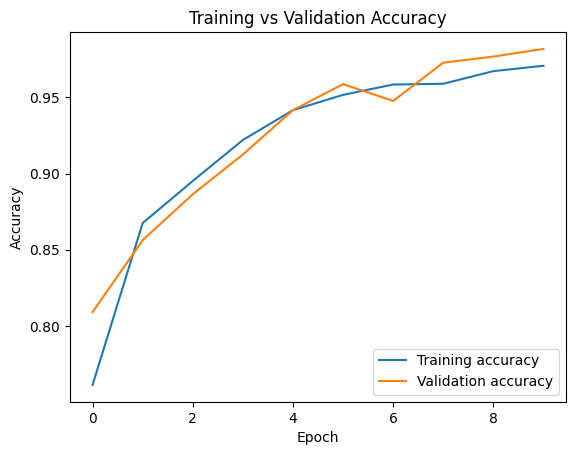

In [15]:
# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Load ERA5-Land data for 2023
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
              .filterBounds(region_of_interest) \
              .filterDate('2023-01-01', '2023-12-31')

# Function to calculate wind speed from u10 and v10 components
def calc_wind_speed(image):
    u10 = image.select('u_component_of_wind_100m')
    v10 = image.select('v_component_of_wind_100m')
    wind_speed = u10.pow(2).add(v10.pow(2)).sqrt()
    return image.addBands(wind_speed.rename('wind_speed'))

# Apply wind speed calculation
windSpeed = era5_land.map(calc_wind_speed).select('wind_speed').mean()

# Resample wind speed using bilinear interpolation
resampled_wind_speed = windSpeed.resample('bilinear')

# Select and resample other relevant parameters
airTemp = era5_land.select('temperature_2m').mean().resample('bilinear')
pressure = era5_land.select('surface_pressure').mean().resample('bilinear')

# Load SRTM Digital Elevation Model data
srtm = ee.Image('USGS/SRTMGL1_003')

# Calculate slope and aspect
elevation = srtm.select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(elevation).rename('slope')
aspect = ee.Terrain.aspect(elevation).rename('aspect')

# Combine features into a single dataset
features = windSpeed.addBands([airTemp, pressure, elevation, slope])

# Load power lines and roads datasets
power_lines = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/Powerlines')
roads = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Roads')

# Calculate distance layers
power_lines_image = power_lines.reduceToImage(['dummy'], ee.Reducer.count()).fastDistanceTransform(30).rename('distance_to_power_lines')
roads_image = roads.reduceToImage(['dummy'], ee.Reducer.count()).fastDistanceTransform(30).rename('distance_to_roads')

# Add distance layers to the feature stack
features = features.addBands([power_lines_image, roads_image])

# Load wind farms as a binary classification raster image
wind_farms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')

# Calculate distance to wind farms
distance_to_wind_farms = wind_farms.fastDistanceTransform(30).rename('distance_to_wind_farms')

# Add the distance to wind farms as a band to the features
features = features.addBands(distance_to_wind_farms)

# Sample the updated dataset
sample_data = features.sample(region_of_interest.geometry(), scale=1000, numPixels=5000).getInfo()

# Extract feature data for model training
wind_speed_data = np.array([f['properties']['wind_speed'] for f in sample_data['features']])
air_temp_data = np.array([f['properties']['temperature_2m'] for f in sample_data['features']])
elevation_data = np.array([f['properties']['elevation'] for f in sample_data['features']])
slope_data = np.array([f['properties']['slope'] for f in sample_data['features']])
distance_to_power_lines_data = np.array([f['properties']['distance_to_power_lines'] for f in sample_data['features']])
distance_to_roads_data = np.array([f['properties']['distance_to_roads'] for f in sample_data['features']])
distance_to_wind_farms_data = np.array([f['properties']['distance_to_wind_farms'] for f in sample_data['features']])

# Combine data into the training dataset
X = np.stack([wind_speed_data, air_temp_data, elevation_data, slope_data,
               distance_to_power_lines_data, distance_to_roads_data, distance_to_wind_farms_data], axis=-1)

# Define a binary target variable based on wind speed (e.g., suitability threshold of 5 m/s)
y = np.where(wind_speed_data > 5, 1, 0)

# Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Define CNN model
def create_simple_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (1, 2), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

# Create and train the model
input_shape = (1, X_scaled.shape[1], 1)
model = create_simple_cnn_model(input_shape)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
# Import necessary functions from sklearn.metrics
from sklearn.metrics import mean_absolute_error, roc_curve, auc

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


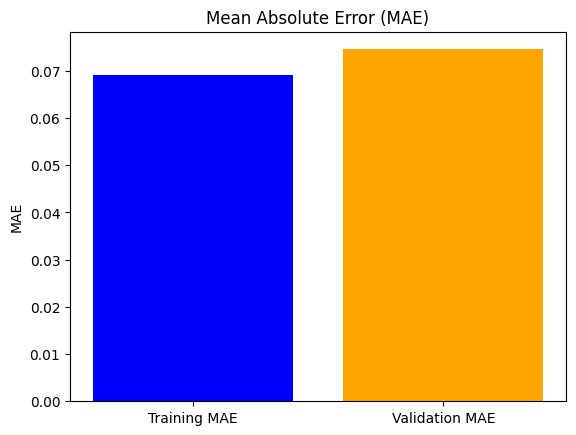

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


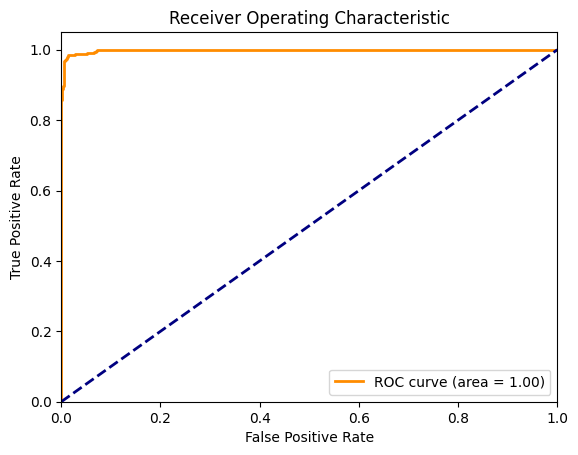

In [17]:
# Plot MAE graph
y_train_pred = model.predict(X_train).ravel()
y_val_pred = model.predict(X_val).ravel()

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

plt.figure()
plt.bar(['Training MAE', 'Validation MAE'], [mae_train, mae_val], color=['blue', 'orange'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.show()

# Plot ROC curve
y_val_prob = model.predict(X_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.metrics import classification_report

# Predict on test set
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

print(classification_report(y_val, y_pred_classes, target_names=["Non-Suitable", "Suitable"]))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

Non-Suitable       0.98      0.99      0.98       535
    Suitable       0.99      0.97      0.98       460

    accuracy                           0.98       995
   macro avg       0.98      0.98      0.98       995
weighted avg       0.98      0.98      0.98       995



In [19]:
# Save the model
model.save('wind_turbine_model.keras')

In [20]:
!pip install folium

In [32]:
import ee
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest: Eastern Cape, South Africa
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')

# Load the datasets
wind_farms = ee.Image('projects/ee-phiwokuhlemadulini747/assets/Binary_Classification_Windfarms')
era5_land = ee.ImageCollection('ECMWF/ERA5/HOURLY').filterDate('2023-01-01', '2023-12-31')
srtm = ee.Image('USGS/SRTMGL1_003')
worldcover = ee.Image('ESA/WorldCover/v100/2020').select('Map').clip(region_of_interest)

# Load roads and powerlines datasets
roads = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Roads')
power_lines = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/Powerlines')

# Define wind speed calculation from ERA5-Land data
def calc_wind_speed(image):
    u100 = image.select('u_component_of_wind_100m')
    v100 = image.select('v_component_of_wind_100m')
    wind_speed = u100.pow(2).add(v100.pow(2)).sqrt()
    return image.addBands(wind_speed.rename('wind_speed'))

# Process wind speed
wind_speed = era5_land.map(calc_wind_speed).select('wind_speed').mean()

# Calculate slope and elevation from SRTM data
elevation = srtm.select('elevation').clip(region_of_interest)
slope = ee.Terrain.slope(elevation).rename('slope')

# Filter WorldCover for suitable land cover types
suitable_landcover = worldcover.updateMask(worldcover.eq(10))

# Assign constant values to roads and power lines datasets
roads_with_constant = roads.map(lambda feature: feature.set('constant', 1))
power_lines_with_constant = power_lines.map(lambda feature: feature.set('constant', 1))

# Convert the roads and power lines datasets to raster images
roads_image = roads_with_constant.reduceToImage(['constant'], ee.Reducer.first())
power_lines_image = power_lines_with_constant.reduceToImage(['constant'], ee.Reducer.first())

# Calculate distances to roads and power lines
distance_to_roads = roads_image.fastDistanceTransform(30).rename('distance_to_roads')
distance_to_power_lines = power_lines_image.fastDistanceTransform(30).rename('distance_to_power_lines')

# Convert wind farm locations to a distance raster
distance_to_wind_farm = wind_farms.fastDistanceTransform(30).rename('distance_to_wind_farm')

# Stack all features (wind speed, elevation, slope, landcover, distances)
features = wind_speed.addBands([
    elevation, slope, suitable_landcover,
    distance_to_wind_farm, distance_to_roads, distance_to_power_lines
])

# Sample data from the region with geometry
sample_data = features.sample(region_of_interest, scale=1000, numPixels=5000, geometries=True).getInfo()

# Extract data into numpy arrays
coords = []
wind_speed_data = []
elevation_data = []
slope_data = []
landcover_data = []
distance_to_wind_farm_data = []
distance_to_roads_data = []
distance_to_power_lines_data = []

for f in sample_data['features']:
    if f['geometry'] and 'coordinates' in f['geometry']:
        coords.append(f['geometry']['coordinates'])
        wind_speed_data.append(f['properties']['wind_speed'])
        elevation_data.append(f['properties']['elevation'])
        slope_data.append(f['properties']['slope'])
        landcover_data.append(f['properties']['Map'])
        distance_to_wind_farm_data.append(f['properties']['distance_to_wind_farm'])
        distance_to_roads_data.append(f['properties']['distance_to_roads'])
        distance_to_power_lines_data.append(f['properties']['distance_to_power_lines'])

# Convert lists to numpy arrays
coords = np.array(coords)
wind_speed_data = np.array(wind_speed_data)
elevation_data = np.array(elevation_data)
slope_data = np.array(slope_data)
landcover_data = np.array(landcover_data)
distance_to_wind_farm_data = np.array(distance_to_wind_farm_data)
distance_to_roads_data = np.array(distance_to_roads_data)
distance_to_power_lines_data = np.array(distance_to_power_lines_data)

# Combine into a dataset for prediction
X = np.stack([
    wind_speed_data, elevation_data, slope_data, landcover_data,
    distance_to_wind_farm_data, distance_to_roads_data, distance_to_power_lines_data
], axis=-1)

# Preprocess the data (scaling, reshaping)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for CNN during training
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)

# Load the saved model
loaded_model = load_model('wind_turbine_model.keras')

# Verify the input shape for prediction
print("Shape of input for prediction:", X_scaled_reshaped.shape)

# Predict on the full dataset
predictions = loaded_model.predict(X_scaled_reshaped)

# Convert predictions to binary (0 for not-suitable, 1 for suitable)
predicted_classes = (predictions > 0.5).astype("int32")

# Filter coordinates where the model predicted "suitable" (class 1)
suitable_coords = coords[predicted_classes.flatten() == 1]

# Save the suitable coordinates
np.save('suitable_coords.npy', suitable_coords)

# Print a confirmation message
print("Suitable coordinates saved to 'suitable_coords.npy'.")


Shape of input for prediction: (505, 1, 7, 1)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Suitable coordinates saved to 'suitable_coords.npy'.


In [34]:
# Load predicted points
suitable_coords = np.load('suitable_coords.npy')

# Function to create a feature from coordinates
def create_feature(coord):
    return ee.Feature(ee.Geometry.Point([coord[0], coord[1]]), {'suitability_value': 10})  # Use explicit key

# Create FeatureCollection
suitable_fc = ee.FeatureCollection([create_feature(coord.tolist()) for coord in suitable_coords])

# Create a raster from points
suitability_raster = suitable_fc.reduceToImage(
    properties=['suitability_value'],  # Match the key used above
    reducer=ee.Reducer.first()
).resample('bilinear')  # Apply resampling for smoothness

# Clip raster to the exact geometry of the region of interest
region_of_interest = ee.FeatureCollection('projects/ee-phiwokuhlemadulini747/assets/EC_Province')
suitability_raster = suitability_raster.clip(region_of_interest.geometry())

# Threshold for high-suitability zones
high_suitability_zone = suitability_raster.gt(7).selfMask()

# Resample the high-suitability zones for smoother visualization
high_suitability_zone = high_suitability_zone.resample('bilinear')

# Clip the resampled high-suitability zones to the region of interest to avoid boundary overlap
high_suitability_zone = high_suitability_zone.clip(region_of_interest.geometry())

# Validate points: Add suitability value from the raster
def add_suitability_value(feature):
    suitability_value = suitability_raster.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=feature.geometry(),
        scale=1000
    ).get('first')  # Use the default key returned by the Reducer
    return feature.set('suitability_value', suitability_value)

validated_points = suitable_fc.map(add_suitability_value)

# Visualization parameters for the suitability raster
suitability_vis_params = {
    'min': 0,  # Lowest value
    'max': 5,  # Highest value
    'palette': ['blue', 'green', 'yellow', 'red']  # Gradual color change
}

# Visualization parameters for high-suitability zones
high_suitability_vis_params = {
    'palette': ['red'],
    'opacity': 0.4
}

# Visualization parameters for the region boundary
region_vis_params = {
    'color': 'gray',
    'fillColor': '#80808080',
    'width': 2
}

# Map visualization
Map = geemap.Map()
Map.centerObject(region_of_interest, 6)
Map.addLayer(region_of_interest.style(**region_vis_params), {}, 'Eastern Cape')
Map.addLayer(
    suitability_raster,
    suitability_vis_params,
    'Suitability Surface (Stretched)'
)
Map.addLayer(high_suitability_zone, high_suitability_vis_params, 'High Suitability Zones (Resampled)')
Map.addLayer(validated_points, {'color': 'blue'}, 'Predicted Points')

# Display the map
Map


Map(center=[-32.15528246336259, 26.467677373363934], controls=(WidgetControl(options=['position', 'transparent…